In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
import pandas as pd
import networkx as nx
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from seql import mc, utils

In [26]:
transition = pd.DataFrame(columns=['^', 'A', 'B', 'AB', 'BA', 'AA', 'BB'], 
                          index=['A', 'B', 'AB', 'BA', 'AA', 'BB'])
transition['^']['A'] = 0.49
transition['^']['B'] = 0.51

transition['A']['AB'] = 0.4
transition['A']['AA'] = 0.6
transition['B']['BA'] = 0.6
transition['B']['BB'] = 0.4


transition['AA']['AA'] = 0.1
transition['AA']['AB'] = 0.9

transition['BA']['AA'] = 0.4
transition['BA']['AB'] = 0.6

transition['AB']['BA'] = 0.7
transition['AB']['BB'] = 0.3

transition['BB']['BA'] = 0.7
transition['BB']['BB'] = 0.3
transition.fillna(0, inplace=True)

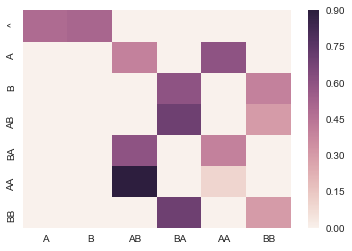

In [27]:
sns.heatmap(transition.T)

In [28]:
def generate_sequence(transition, length):
    seq = []
    for i in range(length):
        if i == 0:
            state = '^'
        elif i == 1:
            state = seq[0]
        else:
            state = ''.join(seq[(i-2):i])
        probas = transition.ix[state]
        probas = probas[probas>0]
        if rand() < probas.max():
            seq.append(probas.idxmax()[-1])
        else:
            
            seq.append(probas.idxmin()[-1])
                
    return seq

In [29]:
def generate_df(sequence, centers, dim=3):
    states = transition.columns
    rnd_data = randn(len(sequence), dim)
    df = pd.DataFrame(index=range(len(sequence)), columns=range(dim))
    for i in range(len(sequence)):
        if i == 0:
            state = sequence[0]
        else:
            state = ''.join(sequence[(i-1):(i+1)])
        df.ix[i] = array(rnd_data[i]) + array(centers[state])
    df['symbol'] = sequence
    return df

In [30]:
dim = 3
centers = {state: rand(dim)*5 for state in transition.index}

sequences = [generate_df(generate_sequence(transition.T, randint(10,30)), centers, dim) for i in range(100)]
for i, seq in enumerate(sequences):
    seq['seq_id'] = i

In [31]:
df = pd.concat(sequences)

In [32]:
df.head()

,0,1,2,symbol,seq_id
0,3.11416,1.1978,4.30246,B,0
1,3.18198,5.73138,4.68412,B,0
2,5.2691,3.99269,2.64728,B,0
3,0.924539,2.12566,4.8189,A,0
4,1.82557,2.89449,0.383213,A,0


In [33]:
model = mc.MarkovChainModel(DecisionTreeClassifier(), 
                            target_label='symbol', sequence_split_label='seq_id', max_state_length=2)

In [34]:
model.fit(df)

MarkovChainModel(base_estimator=CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            cv=3, method='sigmoid'),
         max_state_length=2, min_support=None,
         sequence_split_label='seq_id', target_label='symbol')

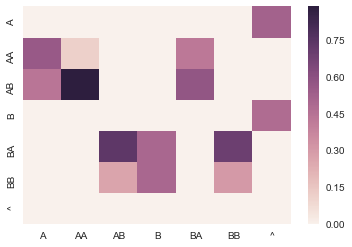

In [35]:
sns.heatmap(model.transition_matrix.T)

In [36]:
model.transition_matrix.T[['^', 'A', 'B', 'AB', 'AA', 'BA', 'BB']].ix[['A', 'B', 'AB', 'AA', 'BA', 'BB']]

,^,A,B,AB,AA,BA,BB
A,0.52,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
B,0.48,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
AB,0.00,0.442308,0.0,0.000000,0.885246,0.574468,0.000000
AA,0.00,0.557692,0.0,0.000000,0.114754,0.425532,0.000000
BA,0.00,0.000000,0.5,0.733224,0.000000,0.000000,0.694444
BB,0.00,0.000000,0.5,0.266776,0.000000,0.000000,0.305556


In [37]:
transition[['^', 'A', 'B', 'AB', 'AA', 'BA', 'BB']].ix[['A', 'B', 'AB', 'AA', 'BA', 'BB']]

,^,A,B,AB,AA,BA,BB
A,0.49,0.0,0.0,0.0,0.0,0.0,0.0
B,0.51,0.0,0.0,0.0,0.0,0.0,0.0
AB,0.00,0.4,0.0,0.0,0.9,0.6,0.0
AA,0.00,0.6,0.0,0.0,0.1,0.4,0.0
BA,0.00,0.0,0.6,0.7,0.0,0.0,0.7
BB,0.00,0.0,0.4,0.3,0.0,0.0,0.3


In [38]:
print(model.suffix_tree.render())

SuffixTree('/root', count=1979, states=['^', 'B', 'A', 'BB', 'BA', 'AA', 'AB'])
├── Node('/root/B', count=956)
│   ├── Node('/root/B/BB', count=264)
│   └── Node('/root/B/AB', count=644)
└── Node('/root/A', count=1023)
    ├── Node('/root/A/BA', count=647)
    └── Node('/root/A/AA', count=324)


In [39]:
import scipy.spatial.distance as distance

In [41]:
distance.cosine(transition[['^', 'A', 'B', 'AB', 'AA', 'BA', 'BB']].ix[['A', 'B', 'AB', 'AA', 'BA', 'BB']].values.flatten(),
               model.transition_matrix.T[['^', 'A', 'B', 'AB', 'AA', 'BA', 'BB']].ix[['A', 'B', 'AB', 'AA', 'BA', 'BB']].values.flatten())

0.0036426955933640537

In [29]:
sequences = [df[model.target_label][df[model.sequence_split_label] == val]
                     for val in df[model.sequence_split_label].unique()]

In [51]:
states = ['A', 'B', 'AB', 'AA', 'BA', 'BB']#,  'AAA', 'ABA', 'AAB', 'ABB', 'BBB','BBA', 'BAA', 'BAB']
trans = pd.DataFrame(columns=states, index=states)
trans.fillna(0, inplace=True)

In [39]:
import networkx as nx

In [40]:
g = nx.DiGraph()

In [47]:
for seq in sequences:
    seq = ''.join(seq)
    for state_len in [1,2]:
        for i in range(len(seq)-state_len):

In [54]:
for seq in sequences:
    seq = ''.join(seq)
    for state_len in [1,2]:
        for i in range(len(seq)-state_len):
            prev = seq[i:(i+state_len)]
            print(prev, end='|')
            for nxt_state_len in [2,1]:
                if nxt_state_len > state_len:
                    nxt = seq[(i+1-state_len):(i+nxt_state_len+1-state_len)]
                else:
                    nxt = seq[(i+1):(i+nxt_state_len+1)]
                if nxt in trans.columns:
                    break
            print(nxt)
            trans.ix[prev][nxt] += 1

B|BB
B|BA
A|AA
A|AB
B|BA
A|AB
B|BA
A|AB
B|BB
B|BA
A|AB
B|BA
A|AA
A|AB
B|BB
B|BA
A|AB
B|BA
A|AB
B|BA
A|AB
B|BA
A|AA
A|AB
B|BB
B|BA
BB|BA
BA|AA
AA|AB
AB|BA
BA|AB
AB|BA
BA|AB
AB|BB
BB|BA
BA|AB
AB|BA
BA|AA
AA|AB
AB|BB
BB|BA
BA|AB
AB|BA
BA|AB
AB|BA
BA|AB
AB|BA
BA|AA
AA|AB
AB|BB
BB|BA
A|AA
A|AB
B|BB
B|BA
A|AA
A|AB
B|BA
A|AB
B|BA
A|AB
B|BA
A|AA
A|AB
B|BA
A|AA
A|AB
B|BB
B|BA
A|AB
B|BA
A|AB
AA|AB
AB|BB
BB|BA
BA|AA
AA|AB
AB|BA
BA|AB
AB|BA
BA|AB
AB|BA
BA|AA
AA|AB
AB|BA
BA|AA
AA|AB
AB|BB
BB|BA
BA|AB
AB|BA
BA|AB
B|BA
A|AB
B|BB
B|BA
A|AA
A|AB
B|BA
A|AA
A|AB
B|BA
BA|AB
AB|BB
BB|BA
BA|AA
AA|AB
AB|BA
BA|AA
AA|AB
AB|BA
A|AB
B|BA
A|AB
B|BA
A|AB
B|BA
A|AA
A|AB
B|BA
A|AB
B|BA
A|AB
B|BA
AB|BA
BA|AB
AB|BA
BA|AB
AB|BA
BA|AA
AA|AB
AB|BA
BA|AB
AB|BA
BA|AB
AB|BA
A|AB
B|BA
A|AA
A|AB
B|BB
B|BA
A|AB
B|BB
B|BB
B|BB
B|BA
A|AB
B|BA
A|AB
B|BB
B|BA
A|AB
B|BA
A|AB
AB|BA
BA|AA
AA|AB
AB|BB
BB|BA
BA|AB
AB|BB
BB|BB
BB|BB
BB|BA
BA|AB
AB|BA
BA|AB
AB|BB
BB|BA
BA|AB
AB|BA
BA|AB
A|AB
B|BB
B|BB
B|BA
A|AB
B|BA
A|AA
A|AB
B|BA
A|AA
A

In [55]:
trans

,A,B,AB,AA,BA,BB
A,0,0,1228,568,0,0
B,0,0,0,0,1234,536
AB,0,0,0,0,818,334
AA,0,0,488,56,0,0
BA,0,0,702,456,0,0
BB,0,0,0,0,348,164


In [56]:
for state in states:
    trans.ix[state] /= trans.ix[state].sum()

In [57]:
trans

,A,B,AB,AA,BA,BB
A,0.0,0.0,0.683742,0.316258,0.000000,0.000000
B,0.0,0.0,0.000000,0.000000,0.697175,0.302825
AB,0.0,0.0,0.000000,0.000000,0.710069,0.289931
AA,0.0,0.0,0.897059,0.102941,0.000000,0.000000
BA,0.0,0.0,0.606218,0.393782,0.000000,0.000000
BB,0.0,0.0,0.000000,0.000000,0.679688,0.320312


In [45]:
transition

,^,A,B,AB,BA,AA,BB
A,0.49,0.0,0.0,0.0,0.0,0.0,0.0
B,0.51,0.0,0.0,0.0,0.0,0.0,0.0
AB,0.00,0.4,0.0,0.0,0.6,0.9,0.0
BA,0.00,0.0,0.6,0.7,0.0,0.0,0.7
AA,0.00,0.6,0.0,0.0,0.4,0.1,0.0
BB,0.00,0.0,0.4,0.3,0.0,0.0,0.3


In [23]:
for k, v in trans.iterkv():
    for k1, v1 in v.iterkv():
        print(k, k1, v1)
    break

NameError: name 'trans' is not defined

In [ ]:
# find other metrics for matrix similarity
norm(model.transition_matrix.T - transition.T) / norm(transition.T)

In [ ]:
new_sequences = [generate_df(generate_sequence(transition.T, randint(10,30)), centers, dim) for i in range(1)]

In [ ]:
last, states = model.query(new_sequences[0].iloc[:,:3], return_states_history=True)

In [ ]:
''.join(val[-1] for val in states.values[2:])

In [ ]:
''.join(new_sequences[0].symbol.values[2:])